# Advanced Automatic Differentiation

## 1. Setup

In [1]:
import tensorflow as tf

# TensorFlow: Blas GEMM launch failed
physical_devices = tf.config.list_physical_devices('GPU') 
tf.config.experimental.set_memory_growth(physical_devices[0], True)

import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
mpl.rcParams['figure.figsize'] = (8, 6)

print("The version of Tensorflow: {}".format(tf.__version__))

The version of Tensorflow: 2.4.1


## 2. Controlling gradient recording

In [2]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  x_sq = x * x
  with t.stop_recording():
    y_sq = y * y
  z = x_sq + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


In [3]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)
reset = True

with tf.GradientTape() as t:
  y_sq = y * y
  if reset:
    # Throw out all the tape recorded so far
    t.reset()
  z = x * x + y_sq

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


## 3. Stop gradient

In [4]:
x = tf.Variable(2.0)
y = tf.Variable(3.0)

with tf.GradientTape() as t:
  y_sq = y**2
  z = x**2 + tf.stop_gradient(y_sq)

grad = t.gradient(z, {'x': x, 'y': y})

print('dz/dx:', grad['x'])  # 2*x => 4
print('dz/dy:', grad['y'])

dz/dx: tf.Tensor(4.0, shape=(), dtype=float32)
dz/dy: None


## 4. Custom gradients

In [5]:
# Establish an identity operation, but clip during the gradient pass
@tf.custom_gradient
def clip_gradients(y):
  def backward(dy):
    return tf.clip_by_norm(dy, 0.5)
  return y, backward

v = tf.Variable(2.0)
with tf.GradientTape() as t:
  output = clip_gradients(v * v)
print(t.gradient(output, v))  # calls "backward", which clips 4 to 2

tf.Tensor(2.0, shape=(), dtype=float32)


## 5. Multiple tapes

In [6]:
# Multiple tapes interact seamlessly. For example, here each tape watches a different set of tensors:

x0 = tf.constant(0.0)
x1 = tf.constant(0.0)

with tf.GradientTape() as tape0, tf.GradientTape() as tape1:
  tape0.watch(x0)
  tape1.watch(x1)

  y0 = tf.math.sin(x0)
  y1 = tf.nn.sigmoid(x1)

  y = y0 + y1

  ys = tf.reduce_sum(y)

In [7]:
tape0.gradient(ys, x0).numpy()   # cos(x) => 1.0

1.0

In [8]:
tape1.gradient(ys, x1).numpy()   # sigmoid(x1)*(1-sigmoid(x1)) => 0.25

0.25

### Higher-order gradients

In [9]:
x = tf.Variable(1.0)  # Create a Tensorflow variable initialized to 1.0

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    y = x * x * x

  # Compute the gradient inside the outer `t2` context manager
  # which means the gradient computation is differentiable as well.
  dy_dx = t1.gradient(y, x)
d2y_dx2 = t2.gradient(dy_dx, x)

print('dy_dx:', dy_dx.numpy())  # 3 * x**2 => 3.0
print('d2y_dx2:', d2y_dx2.numpy())  # 6 * x => 6.0

dy_dx: 3.0
d2y_dx2: 6.0


### Example: Input gradient regularization

In [10]:
x = tf.random.normal([7, 5])

layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

In [11]:
with tf.GradientTape() as t2:
  # The inner tape only takes the gradient with respect to the input,
  # not the variables.
  with tf.GradientTape(watch_accessed_variables=False) as t1:
    t1.watch(x)
    y = layer(x)
    out = tf.reduce_sum(layer(x)**2)
  # 1. Calculate the input gradient.
  g1 = t1.gradient(out, x)
  # 2. Calculate the magnitude of the input gradient.
  g1_mag = tf.norm(g1)

# 3. Calculate the gradient of the magnitude with respect to the model.
dg1_mag = t2.gradient(g1_mag, layer.trainable_variables)

In [12]:
[var.shape for var in dg1_mag]

[TensorShape([5, 10]), TensorShape([10])]

## 6. Jacobians

### [Jacobian matrix](https://en.wikipedia.org/wiki/Jacobian_matrix_and_determinant)

### i. Scalar source

In [13]:
# As a first example, here is the Jacobian of a vector-target with respect to a scalar-source.

x = tf.linspace(-10.0, 10.0, 200+1)
delta = tf.Variable(0.0)

with tf.GradientTape() as tape:
  y = tf.nn.sigmoid(x+delta)

dy_dx = tape.jacobian(y, delta)

In [14]:
print(y.shape)
print(dy_dx.shape)

(201,)
(201,)


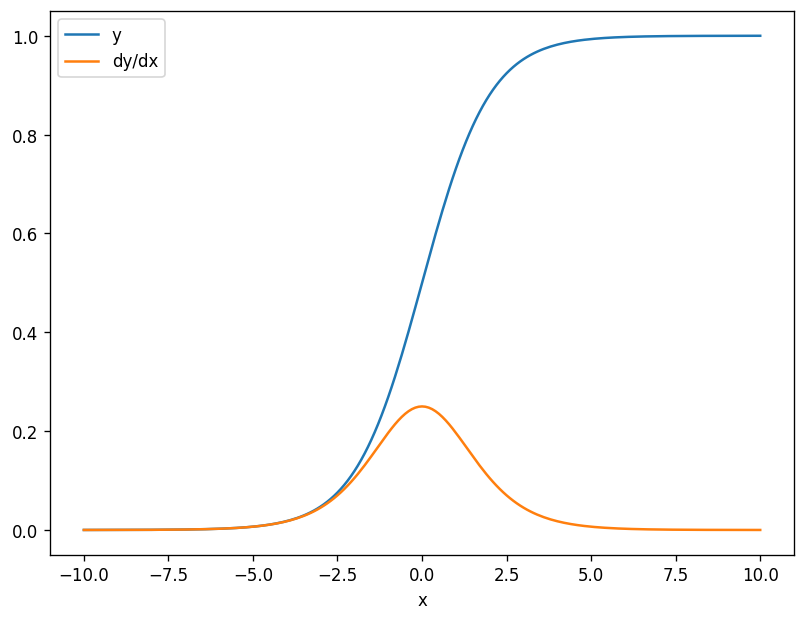

In [15]:
plt.figure(dpi=120)
plt.plot(x.numpy(), y, label='y')
plt.plot(x.numpy(), dy_dx, label='dy/dx')
plt.legend()
_ = plt.xlabel('x')

### ii. Tensor source

In [16]:
x = tf.random.normal([7, 5])
layer = tf.keras.layers.Dense(10, activation=tf.nn.relu)

with tf.GradientTape(persistent=True) as tape:
  y = layer(x)

y.shape

TensorShape([7, 10])

In [17]:
# And the layer's kernel's shape is (5, 10):

layer.kernel.shape

TensorShape([5, 10])

In [18]:
# The shape of the Jacobian of the output with respect to the kernel is those two shapes concatenated together:


j = tape.jacobian(y, layer.kernel)
j.shape

TensorShape([7, 10, 5, 10])

In [19]:
# If you sum over the target's dimensions, 
# you're left with the gradient of the sum that would have been calculated by GradientTape.gradient:

g = tape.gradient(y, layer.kernel)
print('g.shape:', g.shape)

j_sum = tf.reduce_sum(j, axis=[0, 1])
delta = tf.reduce_max(abs(g - j_sum)).numpy()
assert delta < 1e-3
print('delta:', delta)

g.shape: (5, 10)
delta: 4.7683716e-07


### Example: Hessian

In [20]:
x = tf.random.normal([7, 5])
layer1 = tf.keras.layers.Dense(8, activation=tf.nn.relu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.relu)

with tf.GradientTape() as t2:
  with tf.GradientTape() as t1:
    x = layer1(x)
    x = layer2(x)
    loss = tf.reduce_mean(x**2)

  g = t1.gradient(loss, layer1.kernel)

h = t2.jacobian(g, layer1.kernel)

In [21]:
print(f'layer.kernel.shape: {layer1.kernel.shape}')
print(f'h.shape: {h.shape}')

layer.kernel.shape: (5, 8)
h.shape: (5, 8, 5, 8)


In [22]:
# To use this Hessian for a Newton's method step, 
# you would first flatten out its axes into a matrix, and flatten out the gradient into a vector:

n_params = tf.reduce_prod(layer1.kernel.shape)

g_vec = tf.reshape(g, [n_params, 1])
h_mat = tf.reshape(h, [n_params, n_params])

In [23]:
# The Hessian matrix should be symmetric:

def imshow_zero_center(image, **kwargs):
  lim = tf.reduce_max(abs(image))
  plt.imshow(image, vmin=-lim, vmax=lim, cmap='seismic', **kwargs)
  plt.colorbar()

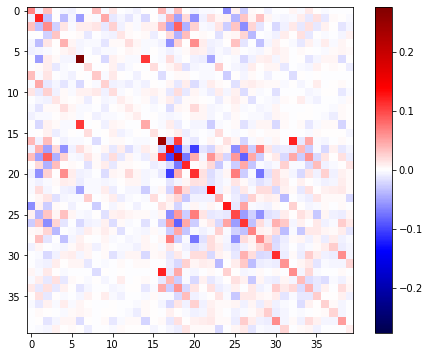

In [24]:
imshow_zero_center(h_mat)

In [25]:
# The Newton's method update step is shown below.

eps = 1e-3
eye_eps = tf.eye(h_mat.shape[0])*eps

In [26]:
# X(k+1) = X(k) - (∇²f(X(k)))^-1 @ ∇f(X(k))
# h_mat = ∇²f(X(k))
# g_vec = ∇f(X(k))
update = tf.linalg.solve(h_mat + eye_eps, g_vec)

# Reshape the update and apply it to the variable.
_ = layer1.kernel.assign_sub(tf.reshape(update, layer1.kernel.shape))

### iii. Batch Jacobian

In [27]:
x = tf.random.normal([7, 5])

layer1 = tf.keras.layers.Dense(8, activation=tf.nn.elu)
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.elu)

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = layer2(y)

y.shape

TensorShape([7, 6])

In [28]:
# The full Jacobian of y with respect to x has a shape of (batch, ins, batch, outs), even if you only want (batch, ins, outs).

j = tape.jacobian(y, x)
j.shape

TensorShape([7, 6, 7, 5])

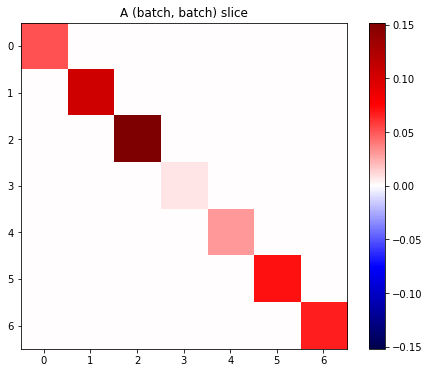

In [29]:
# If the gradients of each item in the stack are independent, 
# then every (batch, batch) slice of this tensor is a diagonal matrix:

imshow_zero_center(j[:, 0, :, 0])
_ = plt.title('A (batch, batch) slice')

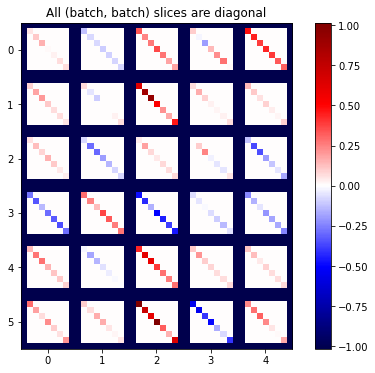

In [30]:
def plot_as_patches(j):
  # Reorder axes so the diagonals will each form a contiguous patch.
  j = tf.transpose(j, [1, 0, 3, 2])
  # Pad in between each patch.
  lim = tf.reduce_max(abs(j))
  j = tf.pad(j, [[0, 0], [1, 1], [0, 0], [1, 1]],
             constant_values=-lim)
  # Reshape to form a single image.
  s = j.shape
  j = tf.reshape(j, [s[0]*s[1], s[2]*s[3]])
  imshow_zero_center(j, extent=[-0.5, s[2]-0.5, s[0]-0.5, -0.5])

plot_as_patches(j)
_ = plt.title('All (batch, batch) slices are diagonal')

In [31]:
# To get the desired result you can sum over the duplicate batch dimension, 
# or else select the diagonals using tf.einsum.

j_sum = tf.reduce_sum(j, axis=2)
print(j_sum.shape)
j_select = tf.einsum('bxby->bxy', j)
print(j_select.shape)

(7, 6, 5)
(7, 6, 5)


In [32]:
jb = tape.batch_jacobian(y, x)
jb.shape

TensorShape([7, 6, 5])

In [33]:
error = tf.reduce_max(abs(jb - j_sum))
assert error < 1e-3
print(error.numpy())

0.0


In [34]:
x = tf.random.normal([7, 5])

layer1 = tf.keras.layers.Dense(8, activation=tf.nn.elu)
bn = tf.keras.layers.BatchNormalization()
layer2 = tf.keras.layers.Dense(6, activation=tf.nn.elu)

with tf.GradientTape(persistent=True, watch_accessed_variables=False) as tape:
  tape.watch(x)
  y = layer1(x)
  y = bn(y, training=True)
  y = layer2(y)

j = tape.jacobian(y, x)
print(f'j.shape: {j.shape}')

j.shape: (7, 6, 7, 5)


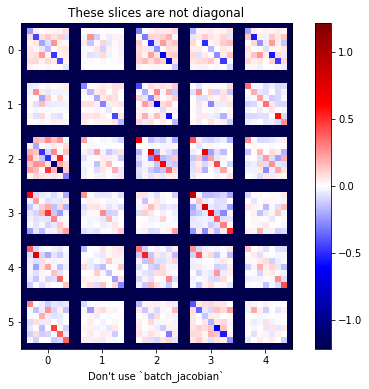

In [35]:
plot_as_patches(j)

_ = plt.title('These slices are not diagonal')
_ = plt.xlabel("Don't use `batch_jacobian`")

In [36]:
jb = tape.batch_jacobian(y, x)
print(f'jb.shape: {jb.shape}')

jb.shape: (7, 6, 5)


# reference

### https://tensorflow.google.cn/guide/advanced_autodiff